# MODEL RSAw -- Fixed Before Conditional Trials

#### Pattern dissimilarity between fixed trials preceding correct and incorrect trials
#### Contains only fixed-before-conditional trials without intervening BLs
#### Combines A & C trials into single regressor
#### Accounts for last three noisy volumes in Lvl 1 analysis (FSL ROI -- ExtractROI)

## Compares activation for regions of interest using binarized masks:
#### Hippocampus (FS labels: hippocampus [17,53])
#### Medial PFC (FS labels: caudal anterior cingulate, rostral anterior cingulate)
#### Dorsal Caudate (hand-drawn by Mandy)
#### Putamen (FS labels: putamen [12,51])
#### Ventral Visual Area (FS labels: fusiform, lingual,  parahippocampal [1007,2007,1013,2013,1016,2016])
#### Dorsolateral PFC (FS labels: caudal middle frontal, lateral orbital frontal, rostral middle frontal [1003,2003,1012,2012,1027,2027])
#### Pars Triangularis (FS labels: triangularis [1020,2020])

In [1]:
import os
import re
from os.path import join
from glob import glob
import nibabel as nb
import pandas as pd
import numpy as np
from scipy import stats
from math import sqrt
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette('muted')
sns.set_style('white')

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']
proj_dir = '/home/data/madlab/Mattfeld_WMAZE/' 
mask_files = []
cope_files = []

for i, SID in enumerate(sids):
    mask_files_glob = glob(proj_dir + 'derivatives/roi_masks/hamm/anat_masks/_subject_id_' +SID+ '/_anatmask_xfm*/*')
    mask_files.append(sorted(mask_files_glob))
    rsc_filenames_glob = glob(proj_dir + 'derivatives/roi_masks/rsc_inepi/' +SID+ '/rsc_temp2epi/_subject_id_' +SID+ '/_targ2EPI*/*')
    mask_files[i].append(rsc_filenames_glob[0])
    subjcopes_glob = glob(proj_dir + 'Hamm_Learning/RSA1/lvl1/fixed/' +SID+
                          '/modelfit/contrasts/_estimate_model*/cope??_all_before_B*')
    cope_files.append(sorted(subjcopes_glob))
    if len(cope_files[-1]) == 0 or len(cope_files[-1]) != 12:
        print(SID, len(cope_files[-1]))

WMAZE_002 10
WMAZE_005 11
WMAZE_006 11
WMAZE_007 11
WMAZE_020 11
WMAZE_023 10


## Cell to double-check the array indexing

In [2]:
#change first index of cope_files to indicate participant index in sids array
for i, curr_mask in enumerate(mask_files[0]):
    print(i, mask_files[0][i].split('/')[-1][:-7]) 

0 lh-all_mPFC_warped
1 lh-dlPFC_warped
2 lh-dmPFC_warped
3 lh-hippocampus_warped
4 lh-mPFC_fs-3reg_warped
5 lh-mPFC_fs_warped
6 lh-mPFC_lausanne_warped
7 lh-motor_warped
8 lh-parsT_warped
9 lh_caudate_anat_mask_warped
10 lh_insula_warped
11 lh_vocc_warped
12 rh_caudate_anat_mask_warped
13 rh-all_mPFC_warped
14 rh-dlPFC_warped
15 rh-dmPFC_warped
16 rh-hippocampus_warped
17 rh-mPFC_fs-3reg_warped
18 rh-mPFC_fs_warped
19 rh-mPFC_lausanne_warped
20 rh-motor_warped
21 rh-parsT_warped
22 rh_insula_warped
23 rh_vocc_warped
24 lh-putamen_warped
25 lh_dlpfc_warped
26 lh_dlpfc_warped
27 rh-putamen_warped
28 CCOPY_T_wmaze_template_trans


In [3]:
for i, curr_cope in enumerate(cope_files[0]):
    print(i, cope_files[0][i].split('/')[-2][-1], cope_files[0][i].split('/')[-1][7:-7]) 

0 0 all_before_B_corr
1 0 all_before_B_incorr
2 1 all_before_B_corr
3 1 all_before_B_incorr
4 2 all_before_B_corr
5 2 all_before_B_incorr
6 3 all_before_B_corr
7 3 all_before_B_incorr
8 4 all_before_B_corr
9 4 all_before_B_incorr
10 5 all_before_B_corr
11 5 all_before_B_incorr


### Use binarized mask to obtain activation in left & right hemisphere for each region of interest

In [4]:
all_data = {}
for r in ['hp', 'mpfc', 'caud', 'put', 'dlpfc', 'vocc', 'rsc', 'parsT']:
    all_data['{0}'.format(r)] = {'run1_corr':[], 'run1_incorr':[], 'run2_corr':[], 'run2_incorr':[], #set1
                                 'run3_corr':[], 'run3_incorr':[], 'run4_corr':[], 'run4_incorr':[], #set2
                                 'run5_corr':[], 'run5_incorr':[], 'run6_corr':[], 'run6_incorr':[]} #set3
for i in range(len(sids)):
    lh_hp_img = nb.load(mask_files[i][3])
    rh_hp_img = nb.load(mask_files[i][16])
    lh_mpfc_img = nb.load(mask_files[i][5])
    rh_mpfc_img = nb.load(mask_files[i][18])
    lh_caud_img = nb.load(mask_files[i][9])
    rh_caud_img = nb.load(mask_files[i][12])
    lh_put_img = nb.load(mask_files[i][24])
    rh_put_img = nb.load(mask_files[i][27])
    lh_dlpfc_img = nb.load(mask_files[i][1])
    rh_dlpfc_img = nb.load(mask_files[i][14])
    lh_vocc_img = nb.load(mask_files[i][11])
    rh_vocc_img = nb.load(mask_files[i][23])
    lh_parsT_img = nb.load(mask_files[i][8])
    rh_parsT_img = nb.load(mask_files[i][21])
    bi_rsc_img = nb.load(mask_files[i][28])
    
    run1_corr_img = None
    run1_incorr_img = None
    run2_corr_img = None
    run2_incorr_img = None
    run3_corr_img = None
    run3_incorr_img = None
    run4_corr_img = None
    run4_incorr_img = None
    run5_corr_img = None
    run5_incorr_img = None
    run6_corr_img = None
    run6_incorr_img = None
    
    set1 = [x for x in cope_files[i] if 'model0' in x or 'model1' in x] #grab if files exist for run1/2
    set2 = [x for x in cope_files[i] if 'model2' in x or 'model3' in x] 
    set3 = [x for x in cope_files[i] if 'model4' in x or 'model5' in x]
    
    for j, frst_run in enumerate(range(1,6,2)): #loads data for each set          
        if len(eval('set{0}'.format(j+1))) != 4: #if there are not 4 files (missing corr/incorr for one of the 2 runs)
            for key in ["hp","mpfc","caud","put","dlpfc","vocc","rsc","parsT"]:
                for acc in ["corr", "incorr"]: #append nan to all four keys                     
                    all_data['{0}'.format(key)]['run{0}_{1}'.format(frst_run,acc)].append("nan")
                    all_data['{0}'.format(key)]['run{0}_{1}'.format(frst_run+1,acc)].append("nan")
        else: #if all corr/incorr files exist for both runs
            exec('run{0}_corr_img = nb.load(set{1}[0])'.format(frst_run,j+1))
            exec('run{0}_incorr_img = nb.load(set{1}[1])'.format(frst_run,j+1))
            exec('run{0}_corr_img = nb.load(set{1}[2])'.format(frst_run+1,j+1))
            exec('run{0}_incorr_img = nb.load(set{1}[3])'.format(frst_run+1,j+1))    
            
    for key in ['hp', 'mpfc', 'caud', 'put', 'dlpfc', 'vocc', 'parsT']: #combines masked hemisphere regions, appends to dict
        for run in ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']:
            for acc in ['corr', 'incorr']: 
                if eval('{0}_{1}_img'.format(run,acc)) == None: #if run/acc mask does not exist, skip
                    continue
                else:
                    lh_data = eval('{0}_{1}_img.get_data()[lh_{2}_img.get_data() > 0.]'.format(run,acc,key))
                    rh_data = eval('{0}_{1}_img.get_data()[rh_{2}_img.get_data() > 0.]'.format(run,acc,key))
                    bihemi_data = np.concatenate((lh_data, rh_data)) 
                    all_data['{0}'.format(key)]['{0}_{1}'.format(run,acc)].append(bihemi_data)                    
    for run in ['run1', 'run2', 'run3', 'run4', 'run5', 'run6']: #appends masked rsc to dict
        for acc in ['corr', 'incorr']:
            if eval('{0}_{1}_img'.format(run,acc)) == None:
                continue
            else:
                bihemi_data = eval('{0}_{1}_img.get_data()[bi_rsc_img.get_data()[:,:,:,0] > 0.]'.format(run,acc))
                all_data['rsc']['{0}_{1}'.format(run,acc)].append(bihemi_data)  
                
for key in all_data: #creates individual region dfs
    exec('{0}_df = pd.DataFrame(all_data["{0}"])'.format(key))
all_data_df = pd.DataFrame(all_data) #turns dict to Panda's DF   

<string>:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [5]:
all_corrs = {}
for r in ['hp', 'mpfc', 'caud', 'put', 'dlpfc', 'vocc', 'rsc', 'parsT']:
    all_corrs['{0}'.format(r)] = {'s1r1':[], 's1r2':[], 's2r1':[], 's2r2':[], 's3r1':[], 's3r2':[]}

sids = ['WMAZE_001', 'WMAZE_002', 'WMAZE_004', 'WMAZE_005', 'WMAZE_006', 
        'WMAZE_007', 'WMAZE_008', 'WMAZE_009', 'WMAZE_010', 'WMAZE_012', 
        'WMAZE_017', 'WMAZE_018', 'WMAZE_019', 'WMAZE_020', 'WMAZE_021',  
        'WMAZE_022', 'WMAZE_023', 'WMAZE_024', 'WMAZE_026', 'WMAZE_027']

for x, SID in enumerate(sids):
    for key in all_data:
        for i, frst_run in enumerate(range(1,6,2)):
            if type(eval('{0}_df["run{1}_corr"][x]'.format(key,i*2+1))) is str:
                continue
            else:
                exec('all_corrs["{0}"]["s{1}r1"].append(1-pearsonr({0}_df["run{3}_corr"][{2}],{0}_df["run{3}_incorr"][{2}])[0])'.format(key,i+1,x,i*2+1))
                exec('all_corrs["{0}"]["s{1}r2"].append(1-pearsonr({0}_df["run{3}_corr"][{2}],{0}_df["run{3}_incorr"][{2}])[0])'.format(key,i+1,x,i*2+2))

all_corrs_df = pd.DataFrame(all_corrs)

In [6]:
#all_corrs_df

### Performance Calculation

In [7]:
all_prop_corr = {'s1r1':[], 's1r2':[], 's2r1':[], 's2r2':[],'s3r1':[], 's3r2':[]}
stim_sets = ['1', '2', '3']

for SID in sids:
    sub_dir = '/home/data/madlab/Mattfeld_WMAZE/sourcedata/behav/{0}/'.format(SID)
    dir_file = sorted(glob(join(sub_dir,'{0}_wmazebl_2015*.txt'.format(SID))))   
    early_runs = []
    late_runs = []
    for i, curr_set in enumerate(stim_sets):
        run1 = pd.read_table(dir_file[i*2]) #create dataframe for text files to extract EVS
        run1 = run1[:-3] #removal of the last 3 trials to avoid scanner artifact
        run2 = pd.read_table(dir_file[i*2+1])
        run2 = run2[:-3]
     
        trialtype1 = run1['TrialType'].values
        correct1 = run1['Correct'].values
        trial_shift1 = trialtype1[1:] #shift TrialType back and insert dummy (-1) in last index
        trial_shift1 = np.append(trial_shift1, -1)
        correct_shift1 = correct1[1:] #shift Correct back and insert dummy (-1) in last index
        correct_shift1 = np.append(correct_shift1, -1)        
        corr1 = np.where(((trial_shift1=='B') & (correct_shift1==1)) & (trialtype1!='BL'))[0]
        incorr1 = np.where(((trial_shift1=='B') & (correct_shift1==0)) & (trialtype1!='BL'))[0]
        curr_prop_corr1 = len(corr1)/float(len(corr1) + len(incorr1))
        
        trialtype2 = run2['TrialType'].values
        correct2 = run2['Correct'].values
        trial_shift2 = trialtype2[1:] #shift TrialType back and insert dummy (-1) in last index
        trial_shift2 = np.append(trial_shift2, -1)
        correct_shift2 = correct2[1:] #shift Correct back and insert dummy (-1) in last index
        correct_shift2 = np.append(correct_shift2, -1)        
        corr2 = np.where(((trial_shift2=='B') & (correct_shift2==1)) & (trialtype2!='BL'))[0]
        incorr2 = np.where(((trial_shift2=='B') & (correct_shift2==0)) & (trialtype2!='BL'))[0]
        curr_prop_corr2 = len(corr2)/float(len(corr2) + len(incorr2))
 
        if curr_prop_corr1 == 1.0 or curr_prop_corr2 == 1.0 or curr_prop_corr1 == 0.0 or curr_prop_corr2 == 0.0:
            continue #do not append if either run performance is 100% or 0% correct
        else:
            all_prop_corr['s{0}r1'.format(curr_set)].append(curr_prop_corr1)
            all_prop_corr['s{0}r2'.format(curr_set)].append(curr_prop_corr2)

# Hippocampus

Dissimilarity
Mean s1r1:  0.20673082982168522
STD s1r1:  0.07798229906314878

Mean s1r2:  0.26379382964572984
STD s1r2:  0.15082518375104842

Mean s2r1:  0.24314785066300204
STD s2r1:  0.12063201330990783

Mean s2r2:  0.3372425322917067
STD s2r2:  0.14057811625984634

Mean s3r1:  0.2578237995999324
STD s3r1:  0.11340815792886487

Mean s3r2:  0.3830652295385495
STD s3r2:  0.16646523757616444

Set1 Run1 vs. Run2:
t-test (1.3996170317691357, 0.18071762053123644)
Cohen's d =  0.6520813184479294


<ipython-input-8-f1866aa85db8>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,showcaps=False,


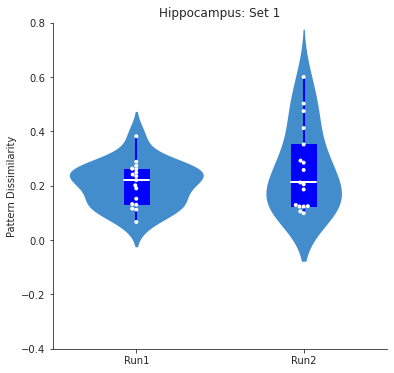

<ipython-input-8-f1866aa85db8>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,showcaps=False,


Set2 Run1 vs. Run2:
t-test (2.308397502078637, 0.03466808838689929)
Cohen's d =  0.9855827609937026


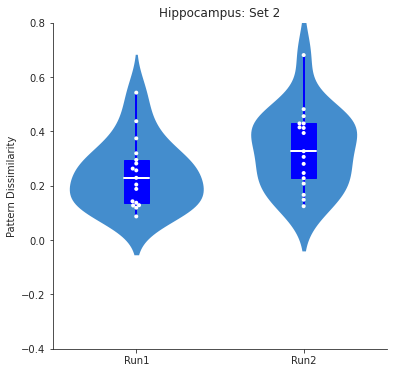

<ipython-input-8-f1866aa85db8>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,showcaps=False,


Set3 Run1 vs. Run2:
t-test (3.489427977282311, 0.0028076627501074287) <---- **
Cohen's d =  1.2085164178522474


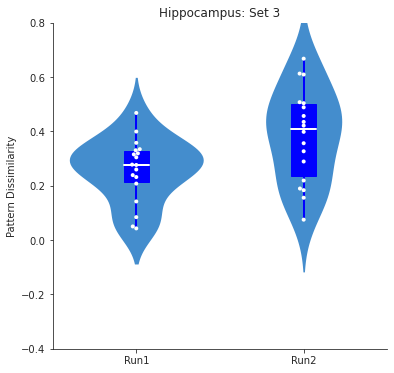

In [8]:
print('Dissimilarity')
for key in ['s1r1', 's1r2','s2r1','s2r2','s3r1','s3r2']:
    print('Mean {0}: '.format(key), np.mean(all_corrs_df['hp']['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(all_corrs_df['hp']['{0}'.format(key)]))
    print('')    
for i in range(3):
    N = 2
    conditions = ['Run1', 'Run2']
    allsubjs = [all_corrs_df['hp']['s{0}r1'.format(i+1)], all_corrs_df['hp']['s{0}r2'.format(i+1)]]
    ind = np.arange(N)
    fig,ax = plt.subplots(figsize=(6,6))
    sns.despine(top=True)
    sns.violinplot(data=allsubjs, color='#278fea', inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,showcaps=False, 
               boxprops=dict(color='blue', facecolor='blue'),
               whiskerprops=dict(color='blue', linewidth=2, linestyle="-"),
               medianprops=dict(color='w', linewidth=2))
    sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylim(-0.4, 0.8)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_ylabel('Pattern Dissimilarity')
    ax.set_title('Hippocampus: Set {0}'.format(i+1))
    print('Set{0} Run1 vs. Run2:'.format(i+1)) 
    #use Shapiro test to determine normality of Run1 and Run2 distributions
    if stats.shapiro(all_corrs_df['hp']['s{0}r2'.format(i+1)])[1] < 0.049 or stats.shapiro(all_corrs_df['hp']['s{0}r1'.format(i+1)])[1] < 0.049:
        #add visual indicators if nonparametric test is significant
        if stats.wilcoxon(all_corrs_df['hp']['s{0}r2'.format(i+1)], 
                          all_corrs_df['hp']['s{0}r1'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(all_corrs_df['hp']['s{0}r2'.format(i+1)], 
                                             all_corrs_df['hp']['s{0}r1'.format(i+1)])[:],'<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(all_corrs_df['hp']['s{0}r2'.format(i+1)], 
                                             all_corrs_df['hp']['s{0}r1'.format(i+1)])[:])
    else: #normal distributions
        if stats.ttest_rel(all_corrs_df['hp']['s{0}r2'.format(i+1)], 
                           all_corrs_df['hp']['s{0}r1'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
            print('t-test', stats.ttest_rel(all_corrs_df['hp']['s{0}r2'.format(i+1)], 
                                            all_corrs_df['hp']['s{0}r1'.format(i+1)])[:],'<---- **')
        else:
            print('t-test', stats.ttest_rel(all_corrs_df['hp']['s{0}r2'.format(i+1)], 
                                            all_corrs_df['hp']['s{0}r1'.format(i+1)])[:]        )
    cohens_d = ((np.average(all_corrs_df['hp']['s{0}r2'.format(i+1)])-np.average(all_corrs_df['hp']['s{0}r1'.format(i+1)])) 
                / (sqrt((np.std(all_corrs_df['hp']['s{0}r2'.format(i+1)],ddof=1))**2 
                   + np.std(all_corrs_df['hp']['s{0}r1'.format(i+1)],ddof=1)**2)/2))
    print ("Cohen's d = ", cohens_d )
    plt.savefig('/home/arenf001/figs/RSAw_F_hpc1_set{0}.png'.format(i+1), dpi=1000)
    plt.show() 

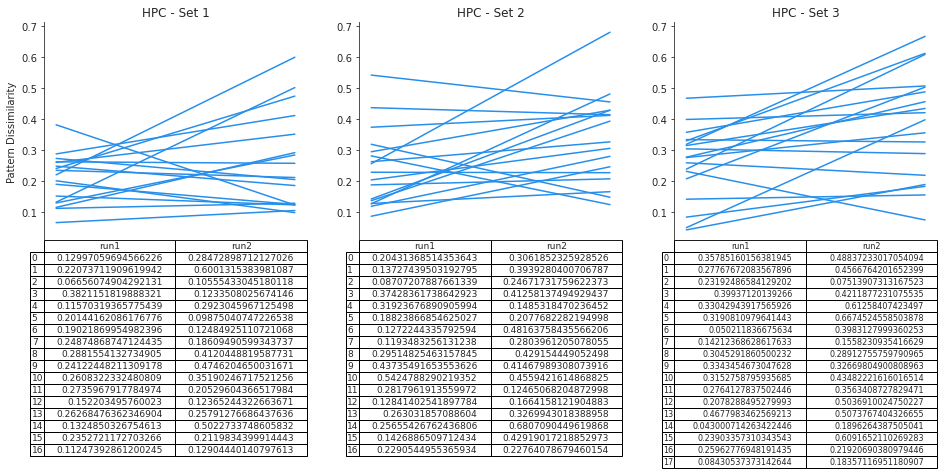

In [9]:
set1 = {}
set2 = {}
set3 = {}
for i in range(3):
    for j in range(2):
        exec('set{0}["run{1}"]=all_corrs_df["hp"]["s{0}r{1}"]'.format(i+1,j+1))
for curr_set in ['set1', 'set2', 'set3']:
    exec('{0}=pd.DataFrame({0})'.format(curr_set)) 
set_conditions = ['Run1', 'Run2']

conditions = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6']
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(16,4), sharex=False, sharey=True)
sns.despine(top=True)

df1 = pd.DataFrame(set1.T)
df2 = pd.DataFrame(set2.T)
df3 = pd.DataFrame(set3.T)
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
df1.plot(table=True, ax=ax1, legend=False, color='#278fea')
df2.plot(table=True, ax=ax2, legend=False, color='#278fea')
df3.plot(table=True, ax=ax3, legend=False, color='#278fea')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylabel('Pattern Dissimilarity')
ax1.set_title('HPC - Set 1')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title('HPC - Set 2')
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_title('HPC - Set 3')
plt.show()

<ipython-input-10-460c2b723c26>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2 = fig.add_subplot(grid[0,1], xticklabels=conditions, sharey=ax1)
<ipython-input-10-460c2b723c26>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3 = fig.add_subplot(grid[0,2], xticklabels=conditions, sharey=ax1)
<ipython-input-10-460c2b723c26>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4 = fig.add_subplot(grid[1,:3], xticklabels=conditions)


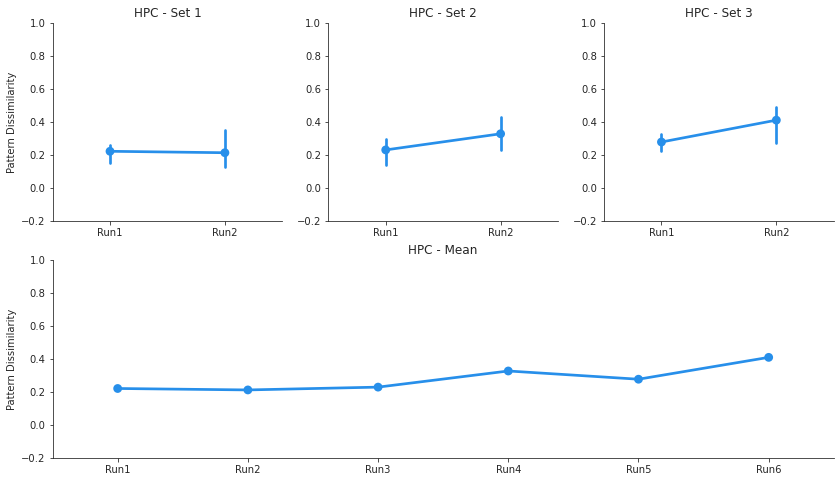

In [10]:
set1 = {}
set2 = {}
set3 = {}
for i in range(3):
    for j in range(2):
        exec('set{0}["run{1}"]=all_corrs_df["hp"]["s{0}r{1}"]'.format(i+1,j+1))
for curr_set in ['set1', 'set2', 'set3']:
    exec('{0}=pd.DataFrame({0})'.format(curr_set)) 
set_conditions = ['Run1', 'Run2']
hp_meansubjs = [all_corrs_df['hp']['s1r1'], all_corrs_df['hp']['s1r2'],
                all_corrs_df['hp']['s2r1'], all_corrs_df['hp']['s2r2'],
                all_corrs_df['hp']['s3r1'], all_corrs_df['hp']['s3r2']]
conditions = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6']
ind = np.arange(N)
fig = plt.figure(figsize=(14,8))
grid = plt.GridSpec(2,3)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1], xticklabels=conditions, sharey=ax1)
ax3 = fig.add_subplot(grid[0,2], xticklabels=conditions, sharey=ax1)
ax4 = fig.add_subplot(grid[1,:3], xticklabels=conditions)
sns.despine(top=True)
sns.pointplot(data=set1, color='#278fea', ax=ax1, estimator=np.median) #using median as metric of centrality
sns.pointplot(data=set2, color='#278fea', ax=ax2, estimator=np.median)
sns.pointplot(data=set3, color='#278fea', ax=ax3, estimator=np.median)
sns.pointplot(data=hp_meansubjs, color='#278fea', ax=ax4, estimator=np.median, ci=False)
ax1.set_xticklabels(set_conditions)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylim(-0.2,1.0)
ax1.set_ylabel('Pattern Dissimilarity')
ax1.set_title('HPC - Set 1')
ax2.set_xticklabels(set_conditions)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title('HPC - Set 2')
ax3.set_xticklabels(set_conditions)
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_title('HPC - Set 3')
ax4.set_xticklabels(conditions)
ax4.yaxis.set_ticks_position('left')
ax4.xaxis.set_ticks_position('bottom')
ax4.set_ylim(-0.2,1.0)
ax4.set_ylabel('Pattern Dissimilarity')
ax4.set_title('HPC - Mean')
plt.show()

SET 1
Early - Run1: (-0.10530364133901053, 0.6875160277603094)
Late - Run1: (0.5003536996521043, 0.04080352381350879)


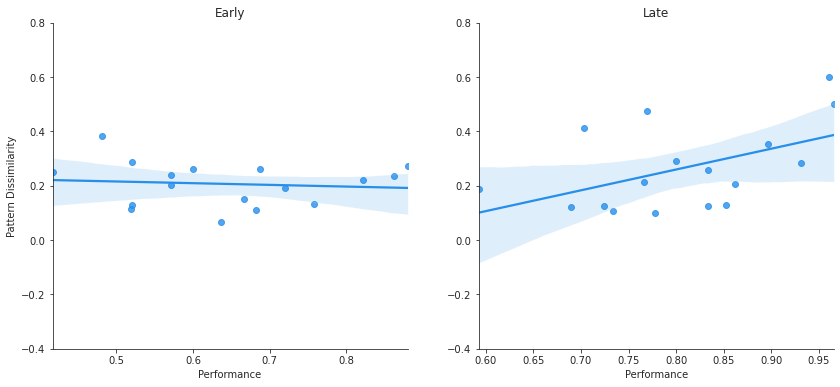

SET 2
Early - Run1: (0.42061030931298093, 0.09273161468223506)
Late - Run1: (0.6849021509529081, 0.0024163159518833686) <---- **


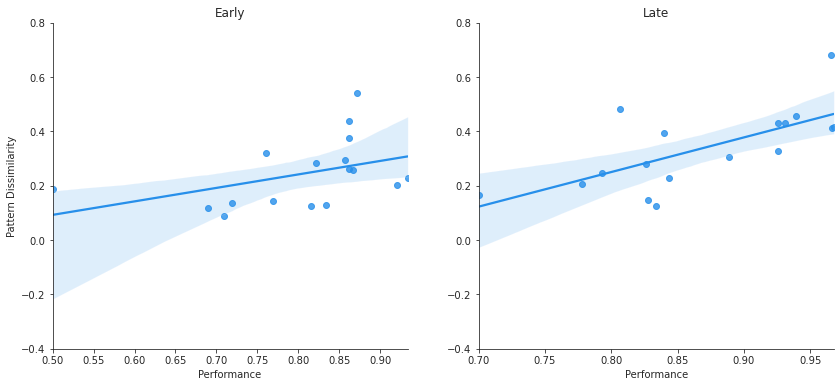

SET 3
Early - Run1: (0.6914480846426481, 0.001481037877920027) <---- **
Late - Run1: (0.5986778929462135, 0.00866379404561927)


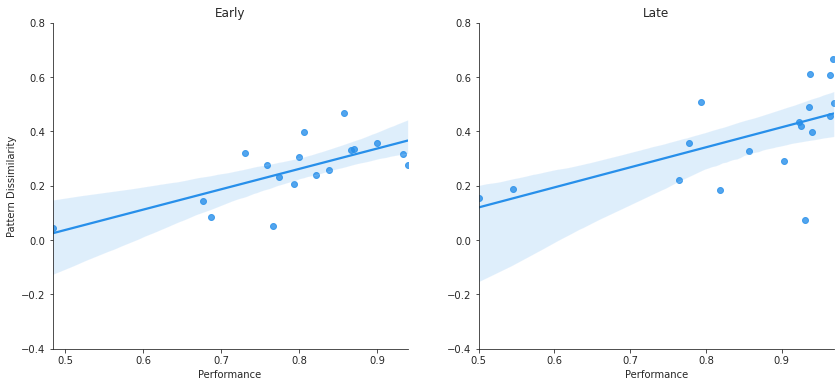

In [11]:
for i in range(3):
    early_plot = {}
    early_plot['brain'] = all_corrs_df['hp']['s{0}r1'.format(i+1)]
    early_plot['behavior'] = all_prop_corr['s{0}r1'.format(i+1)]
    early_plot = pd.DataFrame(early_plot)
    late_plot = {}
    late_plot['brain'] = all_corrs_df['hp']['s{0}r2'.format(i+1)]
    late_plot['behavior'] = all_prop_corr['s{0}r2'.format(i+1)]
    late_plot = pd.DataFrame(late_plot)
    print('SET {0}'.format(i+1)) 
    if pearsonr(early_plot['brain'], early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print('Early - Run1:', pearsonr(early_plot['brain'], early_plot['behavior'])[:], '<---- **')
    else:
        print('Early - Run1:', pearsonr(early_plot['brain'], early_plot['behavior'])[:])
    if pearsonr(late_plot['brain'], late_plot['behavior'])[:][-1] < 0.0083:        
        print('Late - Run1:', pearsonr(late_plot['brain'], late_plot['behavior'])[:], '<---- **')
    else:
        print('Late - Run1:', pearsonr(late_plot['brain'], late_plot['behavior'])[:])
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,6), sharex=False, sharey=True)
    ax1 = sns.regplot(x='behavior', y='brain', data=early_plot, color='#278fea', ax=ax1)
    sns.despine(top=True)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_ylabel('Pattern Dissimilarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    ax1.set_ylim(-0.4,0.8)
    ax2 = sns.regplot(x='behavior', y='brain', data=late_plot, color='#278fea', ax=ax2)
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.set_xlabel('Performance')
    ax2.set_ylabel('')
    ax2.set_title('Late')
    plt.savefig('/home/arenf001/figs/RSAw_F_hpc2_set{0}.png'.format(i+1), dpi=1000)
    plt.show()

## Caudate

Dissimilarity
Mean s1r1:  0.21802017088701284
STD s1r1:  0.07239232227642817

Mean s1r2:  0.2547097277308968
STD s1r2:  0.15881372760752135

Mean s2r1:  0.2267536275994832
STD s2r1:  0.07989846856535998

Mean s2r2:  0.36873751424459095
STD s2r2:  0.15528770198747757

Mean s3r1:  0.24526679788202443
STD s3r1:  0.12225730576404466

Mean s3r2:  0.388360119083686
STD s3r2:  0.13550960295265124

Set1 Run1 vs. Run2:
Wilcoxon (67.0, 0.677703857421875)
Cohen's d =  0.4078735934792285


<ipython-input-12-c6767137d24a>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


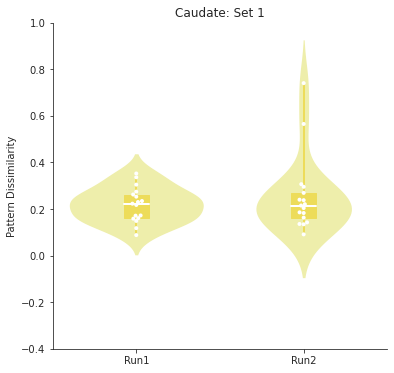

<ipython-input-12-c6767137d24a>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


Set2 Run1 vs. Run2:
t-test (3.549452730927726, 0.002669595351697193) <---- **
Cohen's d =  1.5774974017964076


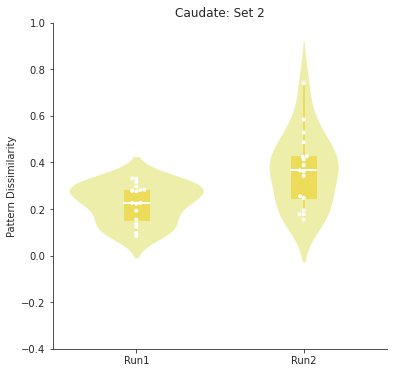

<ipython-input-12-c6767137d24a>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


Set3 Run1 vs. Run2:
t-test (3.8151059122411946, 0.0013846842725453177) <---- **
Cohen's d =  1.5238850148680572


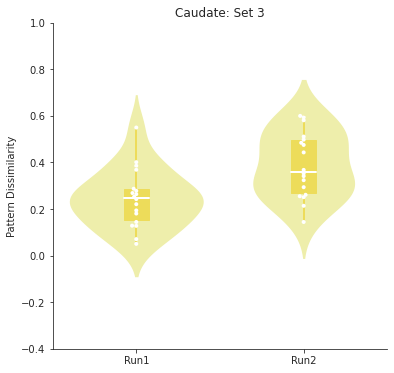

In [12]:
print('Dissimilarity')
for key in ['s1r1', 's1r2','s2r1','s2r2','s3r1','s3r2']:
    print('Mean {0}: '.format(key), np.mean(all_corrs_df['caud']['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(all_corrs_df['caud']['{0}'.format(key)]))
    print('')
    
for i in range(3):
    N = 2
    conditions = ['Run1','Run2']
    allsubjs = [all_corrs_df['caud']['s{0}r1'.format(i+1)], all_corrs_df['caud']['s{0}r2'.format(i+1)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize=(6,6))
    sns.violinplot(data=allsubjs, color='#fcfc9d', inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color='#eddc5a', facecolor='#eddc5a'),
               whiskerprops=dict(color='#eddc5a', linewidth=2, linestyle='-'),
               medianprops=dict(color='w', linewidth=2))
    sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
    sns.despine(top=True)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel('Pattern Dissimilarity')
    ax.set_title('Caudate: Set {0}'.format(i+1))
    ax.set_ylim(-0.4,1.0)
    print('Set{0} Run1 vs. Run2:'.format(i+1))
    if stats.shapiro(all_corrs_df['caud']['s{0}r2'.format(i+1)])[1] < 0.049 or stats.shapiro(all_corrs_df['caud']['s{0}r1'.format(i+1)])[1] < 0.049:
        if stats.wilcoxon(all_corrs_df['caud']['s{0}r2'.format(i+1)], 
                          all_corrs_df['caud']['s{0}r1'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(all_corrs_df['caud']['s{0}r2'.format(i+1)], 
                                             all_corrs_df['caud']['s{0}r1'.format(i+1)])[:], '<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(all_corrs_df['caud']['s{0}r2'.format(i+1)], 
                                             all_corrs_df['caud']['s{0}r1'.format(i+1)])[:])
    else:
        if stats.ttest_rel(all_corrs_df['caud']['s{0}r2'.format(i+1)], 
                           all_corrs_df['caud']['s{0}r1'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
            print('t-test', stats.ttest_rel(all_corrs_df['caud']['s{0}r2'.format(i+1)], 
                                            all_corrs_df['caud']['s{0}r1'.format(i+1)])[:], '<---- **')
        else:
            print('t-test', stats.ttest_rel(all_corrs_df['caud']['s{0}r2'.format(i+1)], 
                                            all_corrs_df['caud']['s{0}r1'.format(i+1)])[:])
    cohens_d = ((np.average(all_corrs_df['caud']['s{0}r2'.format(i+1)])-np.average(all_corrs_df['caud']['s{0}r1'.format(i+1)])) 
                /(sqrt((np.std(all_corrs_df['caud']['s{0}r2'.format(i+1)], ddof=1))**2
                       +np.std(all_corrs_df['caud']['s{0}r1'.format(i+1)], ddof=1)**2)/2))
    print("Cohen's d = ", cohens_d) 
    plt.savefig("/home/arenf001/figs/RSAw_F_caud1_set{0}.png".format(i+1), dpi=1000)
    plt.show()

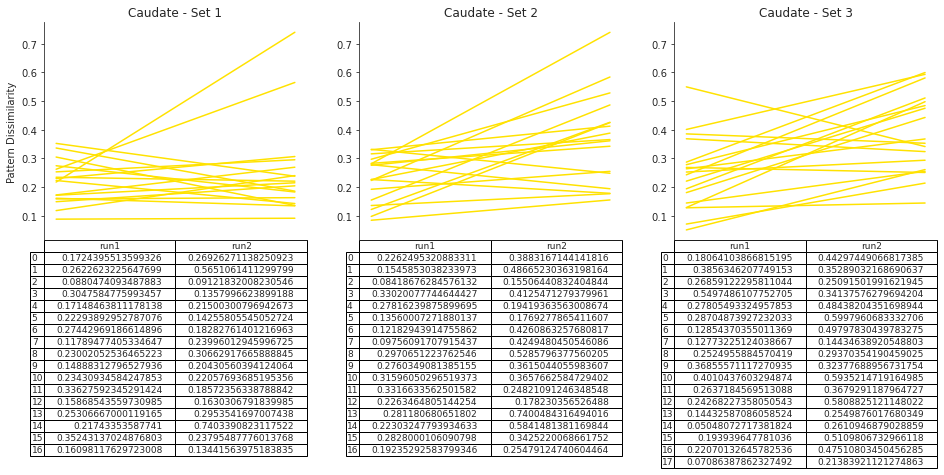

In [13]:
set1 = {}
set2 = {}
set3 = {}
for i in range(3):
    for j in range(2):
        exec('set{0}["run{1}"]=all_corrs_df["caud"]["s{0}r{1}"]'.format(i+1,j+1))
for curr_set in ['set1', 'set2', 'set3']:
    exec('{0}=pd.DataFrame({0})'.format(curr_set)) 
set_conditions = ['Run1', 'Run2']
conditions = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6']
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(16,4), sharex=False, sharey=True)
sns.despine(top=True)
df1 = pd.DataFrame(set1.T)
df2 = pd.DataFrame(set2.T)
df3 = pd.DataFrame(set3.T)
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
df1.plot(table=True, ax=ax1, legend=False, color='#ffe200')
df2.plot(table=True, ax=ax2, legend=False, color='#ffe200')
df3.plot(table=True, ax=ax3, legend=False, color='#ffe200')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylabel('Pattern Dissimilarity')
ax1.set_title('Caudate - Set 1')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title('Caudate - Set 2')
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_title('Caudate - Set 3')
plt.show()

<ipython-input-14-f7584ab7e165>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2 = fig.add_subplot(grid[0,1], xticklabels=conditions, sharey=ax1)
<ipython-input-14-f7584ab7e165>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3 = fig.add_subplot(grid[0,2], xticklabels=conditions, sharey=ax1)
<ipython-input-14-f7584ab7e165>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4 = fig.add_subplot(grid[1,:3], xticklabels=conditions)


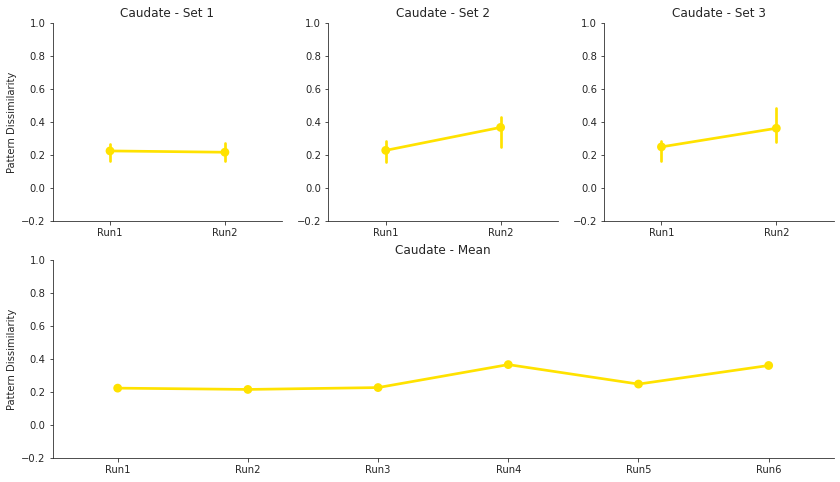

In [14]:
set1 = {}
set2 = {}
set3 = {}
for i in range(3):
    for j in range(2):
        exec('set{0}["run{1}"]=all_corrs_df["caud"]["s{0}r{1}"]'.format(i+1,j+1))
for curr_set in ['set1', 'set2', 'set3']:
    exec('{0}=pd.DataFrame({0})'.format(curr_set)) 
set_conditions = ['Run1', 'Run2']
meansubjs = [all_corrs_df['caud']['s1r1'], all_corrs_df['caud']['s1r2'],
             all_corrs_df['caud']['s2r1'], all_corrs_df['caud']['s2r2'],
             all_corrs_df['caud']['s3r1'], all_corrs_df['caud']['s3r2']]
conditions = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6']
ind = np.arange(N)
fig = plt.figure(figsize=(14,8))
grid = plt.GridSpec(2,3)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1], xticklabels=conditions, sharey=ax1)
ax3 = fig.add_subplot(grid[0,2], xticklabels=conditions, sharey=ax1)
ax4 = fig.add_subplot(grid[1,:3], xticklabels=conditions)
sns.despine(top=True)
sns.pointplot(data=set1, color='#ffe200', ax=ax1, estimator=np.median) 
sns.pointplot(data=set2, color='#ffe200', ax=ax2, estimator=np.median)
sns.pointplot(data=set3, color='#ffe200', ax=ax3, estimator=np.median)
sns.pointplot(data=meansubjs, color='#ffe200', ax=ax4, estimator=np.median, ci=False)
ax1.set_xticklabels(set_conditions)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylim(-0.2,1.0)
ax1.set_ylabel('Pattern Dissimilarity')
ax1.set_title('Caudate - Set 1')
ax2.set_xticklabels(set_conditions)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title('Caudate - Set 2')
ax3.set_xticklabels(set_conditions)
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_title('Caudate - Set 3')
ax4.set_xticklabels(conditions)
ax4.yaxis.set_ticks_position('left')
ax4.xaxis.set_ticks_position('bottom')
ax4.set_ylim(-0.2,1.0)
ax4.set_ylabel('Pattern Dissimilarity')
ax4.set_title('Caudate - Mean')
plt.show()

SET 1
Early - Run1: (0.5513523835674585, 0.021780630376309444)
Late - Run1: (0.5585913609650353, 0.019770545537180894)


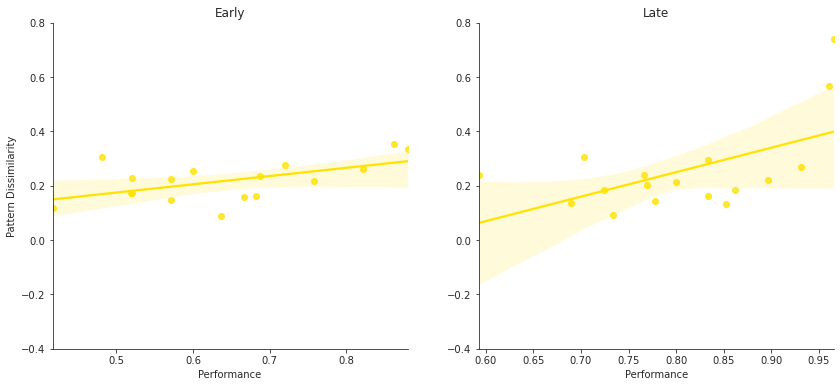

SET 2
Early - Run1: (0.5442109813510714, 0.0239160144636235)
Late - Run1: (0.6216069399479102, 0.007725876300669088) <---- **


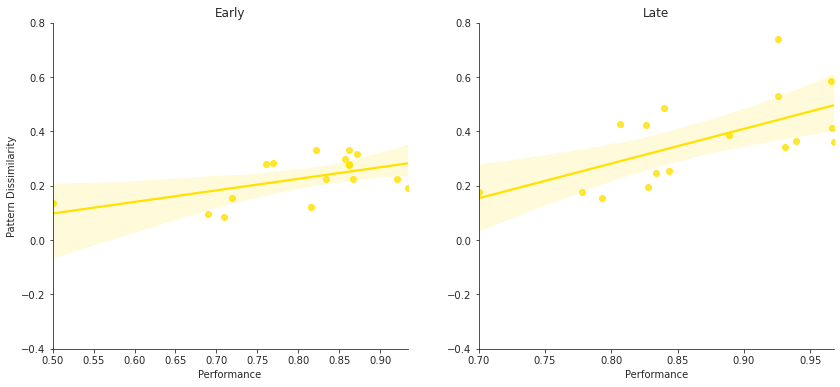

SET 3
Early - Run1: (0.5823535673323275, 0.011216742919031329)
Late - Run1: (0.6271454828565899, 0.005340611165914515) <---- **


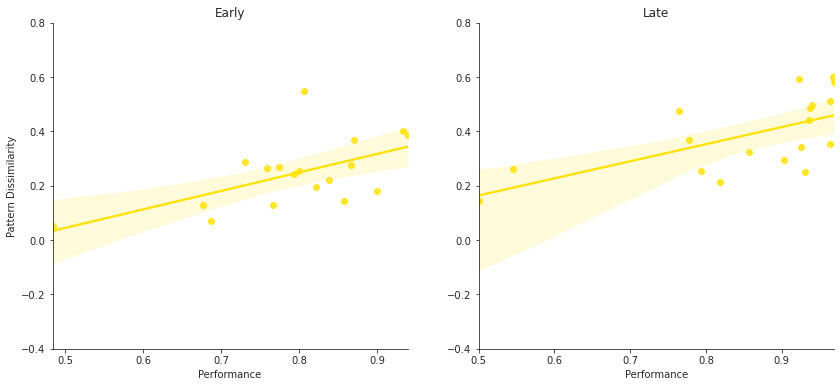

In [15]:
for i in range(3):
    early_plot = {}
    early_plot['brain'] = all_corrs_df['caud']['s{0}r1'.format(i+1)]
    early_plot['behavior'] = all_prop_corr['s{0}r1'.format(i+1)]
    early_plot = pd.DataFrame(early_plot)
    late_plot = {}
    late_plot['brain'] = all_corrs_df['caud']['s{0}r2'.format(i+1)]
    late_plot['behavior'] = all_prop_corr['s{0}r2'.format(i+1)]
    late_plot = pd.DataFrame(late_plot)
    print('SET {0}'.format(i+1))
    if pearsonr(early_plot['brain'], early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print('Early - Run1:', pearsonr(early_plot['brain'], early_plot['behavior'])[:], '<---- **')
    else:
        print('Early - Run1:', pearsonr(early_plot['brain'], early_plot['behavior'])[:])
    if pearsonr(late_plot['brain'], late_plot['behavior'])[:][-1] < 0.0083:        
        print('Late - Run1:', pearsonr(late_plot['brain'], late_plot['behavior'])[:], '<---- **')
    else:
        print('Late - Run1:', pearsonr(late_plot['brain'], late_plot['behavior'])[:])
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,6), sharex=False, sharey=True)
    ax1 = sns.regplot(x='behavior', y='brain', data=early_plot, color='#ffe200', ax=ax1)
    sns.despine(top=True)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_ylabel('Pattern Dissimilarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    ax1.set_ylim(-0.4,0.8)
    ax2 = sns.regplot(x='behavior', y='brain', data=late_plot, color='#ffe200', ax=ax2)
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    plt.savefig('/home/arenf001/figs/RSAw_F_caud2_set{0}.png'.format(i+1), dpi=1000)    
    plt.show()

## Medial PFC

Dissimilarity
Mean s1r1:  0.151649543766736
STD s1r1:  0.06905469384139402

Mean s1r2:  0.2201039294644541
STD s1r2:  0.15973532149745354

Mean s2r1:  0.18882701165882065
STD s2r1:  0.11993402846797113

Mean s2r2:  0.35582319192487344
STD s2r2:  0.20855580668967838

Mean s3r1:  0.2212197568135642
STD s3r1:  0.15204928395939257

Mean s3r2:  0.34088601277002006
STD s3r2:  0.19264207219780136

Set1 Run1 vs. Run2:
Wilcoxon (48.0, 0.190093994140625)
Cohen's d =  0.7632393136508793


<ipython-input-16-e2a6994a8087>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(mpfc_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


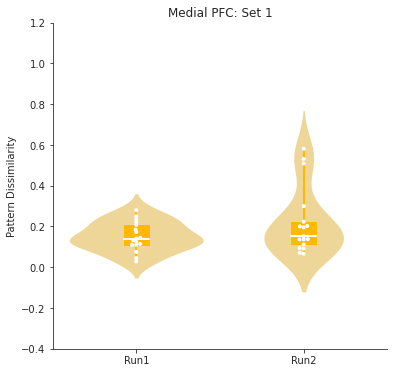

Set2 Run1 vs. Run2:
Wilcoxon (22.0, 0.007904052734375) <---- **
Cohen's d =  1.346818100159477


<ipython-input-16-e2a6994a8087>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(mpfc_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


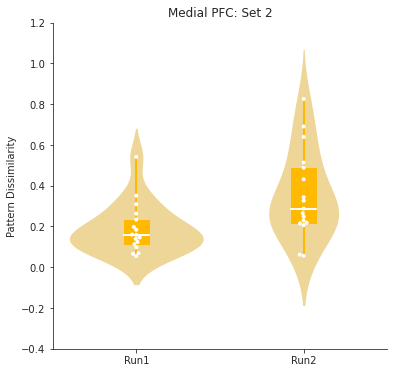

<ipython-input-16-e2a6994a8087>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(mpfc_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


Set3 Run1 vs. Run2:
t-test (3.6091090313790364, 0.002165660750332056) <---- **
Cohen's d =  0.9477278563529797


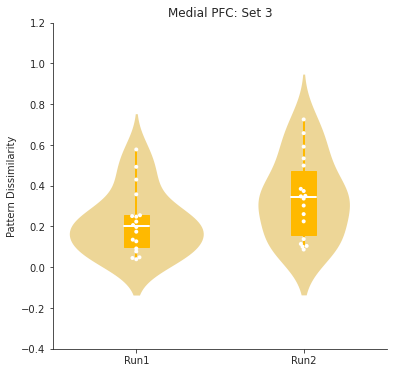

In [16]:
print('Dissimilarity')
for key in ['s1r1', 's1r2','s2r1','s2r2','s3r1','s3r2']:
    print('Mean {0}: '.format(key), np.mean(all_corrs_df['mpfc']['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(all_corrs_df['mpfc']['{0}'.format(key)]))
    print('')
    
for i in range(3):
    N = 2
    conditions = ['Run1', 'Run2']
    mpfc_allsubjs = [all_corrs_df['mpfc']['s{0}r1'.format(i+1)], all_corrs_df['mpfc']['s{0}r2'.format(i+1)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize=(6,6))
    sns.violinplot(data=mpfc_allsubjs, color='#ffde85', inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(mpfc_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color='#ffb900', facecolor='#ffb900'),
               whiskerprops=dict(color='#ffb900', linewidth=2, linestyle="-"),
               medianprops=dict(color='w', linewidth=2))
    sns.swarmplot(data=mpfc_allsubjs, size=4, color='white', edgecolor='gray')
    sns.despine(top=True)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel('Pattern Dissimilarity')
    ax.set_title('Medial PFC: Set {0}'.format(i+1))
    ax.set_ylim(-0.4,1.2)
    print('Set{0} Run1 vs. Run2:'.format(i+1) )
    if stats.shapiro(all_corrs_df['mpfc']['s{0}r2'.format(i+1)])[1] < 0.049 or stats.shapiro(all_corrs_df['mpfc']['s{0}r1'.format(i+1)])[1] < 0.049:
        if stats.wilcoxon(all_corrs_df['mpfc']['s{0}r2'.format(i+1)],
                          all_corrs_df['mpfc']['s{0}r1'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(all_corrs_df['mpfc']['s{0}r2'.format(i+1)],
                                             all_corrs_df['mpfc']['s{0}r1'.format(i+1)])[:], '<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(all_corrs_df['mpfc']['s{0}r2'.format(i+1)],
                                             all_corrs_df['mpfc']['s{0}r1'.format(i+1)])[:])
    else:
        if stats.ttest_rel(all_corrs_df['mpfc']['s{0}r2'.format(i+1)], 
                           all_corrs_df['mpfc']['s{0}r1'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
            print('t-test', stats.ttest_rel(all_corrs_df['mpfc']['s{0}r2'.format(i+1)],
                                            all_corrs_df['mpfc']['s{0}r1'.format(i+1)])[:], '<---- **')
        else:
            print('t-test', stats.ttest_rel(all_corrs_df['mpfc']['s{0}r2'.format(i+1)],
                                            all_corrs_df['mpfc']['s{0}r1'.format(i+1)])[:])
    cohens_d = ((np.average(all_corrs_df['mpfc']['s{0}r2'.format(i+1)])-np.average(all_corrs_df['mpfc']['s{0}r1'.format(i+1)])) 
                / (sqrt((np.std(all_corrs_df['mpfc']['s{0}r2'.format(i+1)], ddof=1))**2
                        +np.std(all_corrs_df['mpfc']['s{0}r1'.format(i+1)], ddof=1)**2)/2))
    print("Cohen's d = ", cohens_d) 
    #plt.savefig('/home/arenf001/figs/RSAw_F_mpfc1_set{0}.png'.format(i+1), dpi=1000)
    plt.show() 

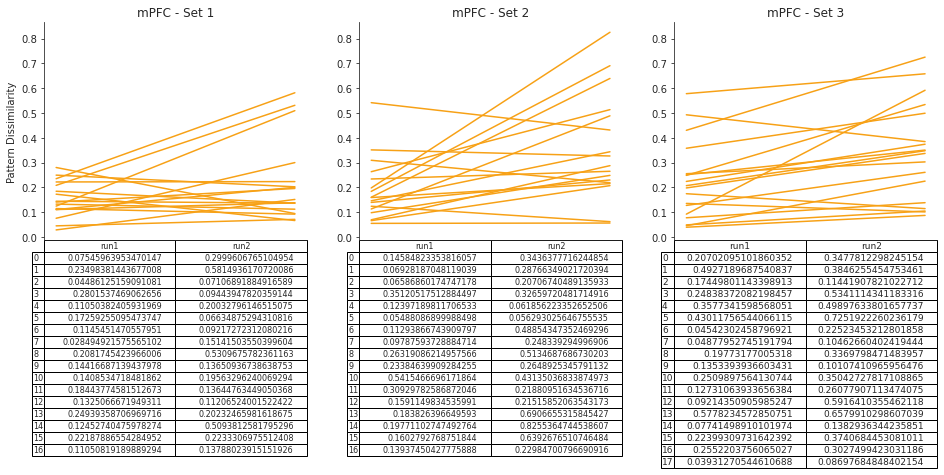

In [17]:
set1 = {}
set2 = {}
set3 = {}
for i in range(3):
    for j in range(2):
        exec('set{0}["run{1}"]=all_corrs_df["mpfc"]["s{0}r{1}"]'.format(i+1,j+1))
for curr_set in ['set1', 'set2', 'set3']:
    exec('{0}=pd.DataFrame({0})'.format(curr_set)) 
set_conditions = ['Run1', 'Run2']
conditions = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6']
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(16,4), sharex=False, sharey=True)
sns.despine(top=True)
df1 = pd.DataFrame(set1.T)
df2 = pd.DataFrame(set2.T)
df3 = pd.DataFrame(set3.T)
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
df1.plot(table=True, ax=ax1, legend=False, color='#f7a116')
df2.plot(table=True, ax=ax2, legend=False, color='#f7a116')
df3.plot(table=True, ax=ax3, legend=False, color='#f7a116')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylabel('Pattern Dissimilarity')
ax1.set_title('mPFC - Set 1')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title('mPFC - Set 2')
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_title('mPFC - Set 3')
plt.show()

<ipython-input-18-ff1471a47c3c>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2 = fig.add_subplot(grid[0,1], xticklabels=conditions, sharey=ax1)
<ipython-input-18-ff1471a47c3c>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3 = fig.add_subplot(grid[0,2], xticklabels=conditions, sharey=ax1)
<ipython-input-18-ff1471a47c3c>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4 = fig.add_subplot(grid[1,:3], xticklabels=conditions)


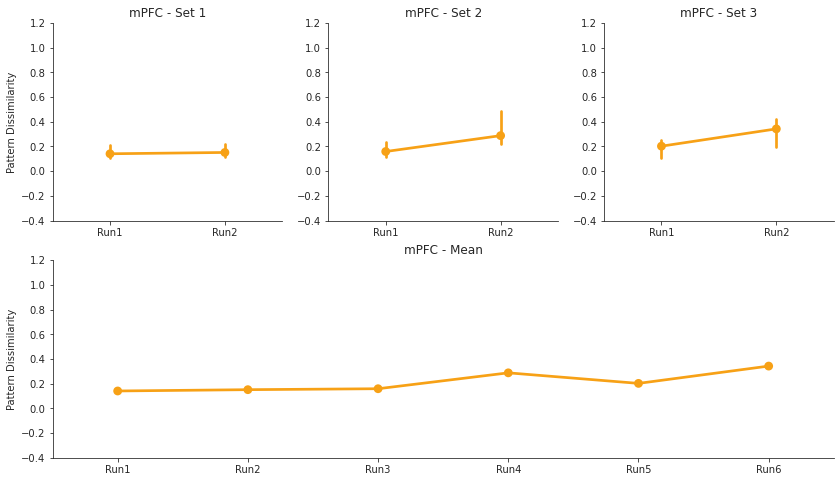

In [18]:
set1 = {}
set2 = {}
set3 = {}
for i in range(3):
    for j in range(2):
        exec('set{0}["run{1}"]=all_corrs_df["mpfc"]["s{0}r{1}"]'.format(i+1,j+1))
for curr_set in ['set1', 'set2', 'set3']:
    exec('{0}=pd.DataFrame({0})'.format(curr_set)) 
set_conditions = ['Run1', 'Run2']
meansubjs = [all_corrs_df['mpfc']['s1r1'], all_corrs_df['mpfc']['s1r2'],
             all_corrs_df['mpfc']['s2r1'], all_corrs_df['mpfc']['s2r2'],
             all_corrs_df['mpfc']['s3r1'], all_corrs_df['mpfc']['s3r2']]
conditions = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6']
ind = np.arange(N)
fig = plt.figure(figsize=(14,8))
grid = plt.GridSpec(2,3)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1], xticklabels=conditions, sharey=ax1)
ax3 = fig.add_subplot(grid[0,2], xticklabels=conditions, sharey=ax1)
ax4 = fig.add_subplot(grid[1,:3], xticklabels=conditions)
sns.despine(top=True)
sns.pointplot(data=set1, color='#f7a116', ax=ax1, estimator=np.median) 
sns.pointplot(data=set2, color='#f7a116', ax=ax2, estimator=np.median)
sns.pointplot(data=set3, color='#f7a116', ax=ax3, estimator=np.median)
sns.pointplot(data=meansubjs, color='#f7a116', ax=ax4, estimator=np.median, ci=False)
ax1.set_xticklabels(set_conditions)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylim(-0.4,1.2)
ax1.set_ylabel('Pattern Dissimilarity')
ax1.set_title('mPFC - Set 1')
ax2.set_xticklabels(set_conditions)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title('mPFC - Set 2')
ax3.set_xticklabels(set_conditions)
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_title('mPFC - Set 3')
ax4.set_xticklabels(conditions)
ax4.yaxis.set_ticks_position('left')
ax4.xaxis.set_ticks_position('bottom')
ax4.set_ylim(-0.4,1.2)
ax4.set_ylabel('Pattern Dissimilarity')
ax4.set_title('mPFC - Mean')
plt.show()

SET 1
Early - Run1: (0.2572333125203055, 0.31890058487456263)
Late - Run1: (0.4629817083679055, 0.061273857453744904)


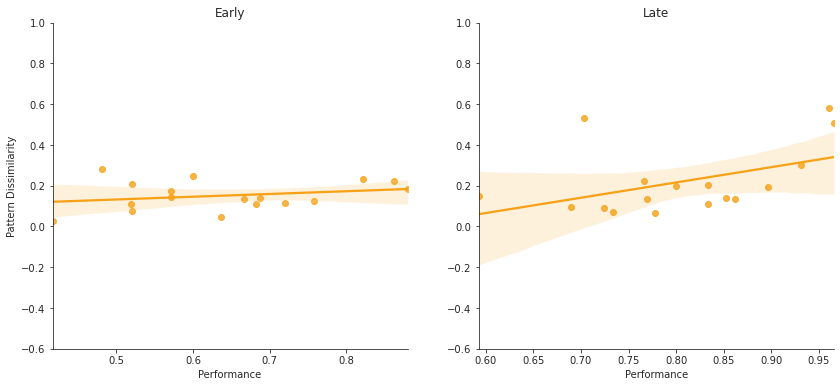

SET 2
Early - Run1: (0.5070317549045084, 0.037774137918004144)
Late - Run1: (0.616084287454613, 0.008453588341058684)


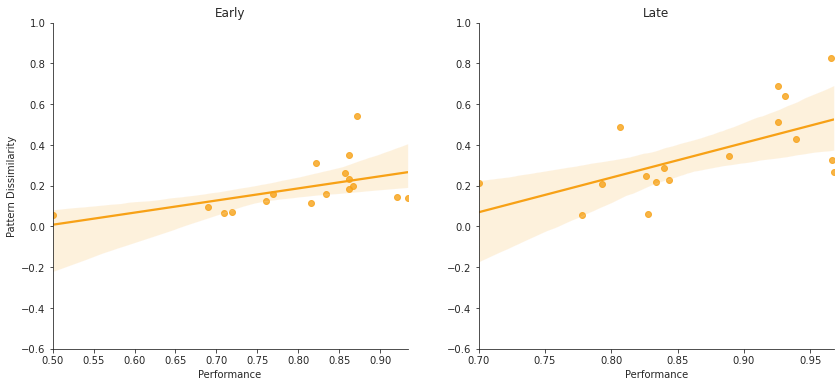

SET 3
Early - Run1: (0.5225402867409012, 0.026095737414515416)
Late - Run1: (0.48319625360881097, 0.04221877901638105)


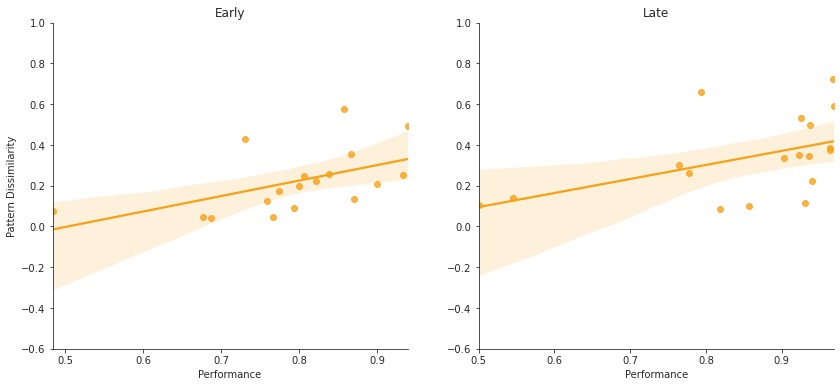

In [19]:
for i in range(3):
    early_plot = {}
    early_plot['brain'] = all_corrs_df['mpfc']['s{0}r1'.format(i+1)]
    early_plot['behavior'] = all_prop_corr['s{0}r1'.format(i+1)]
    early_plot = pd.DataFrame(early_plot)
    late_plot = {}
    late_plot['brain'] = all_corrs_df['mpfc']['s{0}r2'.format(i+1)]
    late_plot['behavior'] = all_prop_corr['s{0}r2'.format(i+1)]
    late_plot = pd.DataFrame(late_plot)
    print('SET {0}'.format(i+1))
    if pearsonr(early_plot['brain'], early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print('Early - Run1:', pearsonr(early_plot['brain'], early_plot['behavior'])[:], '<---- **')
    else:
        print('Early - Run1:', pearsonr(early_plot['brain'], early_plot['behavior'])[:])
    if pearsonr(late_plot['brain'], late_plot['behavior'])[:][-1] < 0.0083:        
        print('Late - Run1:', pearsonr(late_plot['brain'], late_plot['behavior'])[:], '<---- **')
    else:
        print('Late - Run1:', pearsonr(late_plot['brain'], late_plot['behavior'])[:])
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,6), sharex=False, sharey=True)
    ax1 = sns.regplot(x='behavior', y='brain', data=early_plot, color="#f7a116", ax=ax1)
    sns.despine(top=True)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.set_ylabel('Pattern Dissimilarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    ax1.set_ylim(-0.6,1.0)
    ax2 = sns.regplot(x='behavior', y='brain', data=late_plot, color='#f7a116', ax=ax2)
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    ax2.set_ylabel('')
    #plt.savefig('/home/arenf001/figs/RSAw_F_mpfc2_set{0}.png'.format(i+1), dpi=1000)
    plt.show()

## Putamen

Dissimilarity
Mean s1r1:  0.22355669319074925
STD s1r1:  0.07158454691752078

Mean s1r2:  0.26625351338205994
STD s1r2:  0.14120957625962763

Mean s2r1:  0.25134244554776825
STD s2r1:  0.10005521794167342

Mean s2r2:  0.35561771273618303
STD s2r2:  0.12114424962827872

Mean s3r1:  0.24759975015092797
STD s3r1:  0.10856621051965724

Mean s3r2:  0.3792772578810436
STD s3r2:  0.14030767927458815

Set1 Run1 vs. Run2:
Wilcoxon (54.0, 0.3060455322265625)
Cohen's d =  0.5232769529777437


<ipython-input-20-ba6318bba4b5>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(put_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


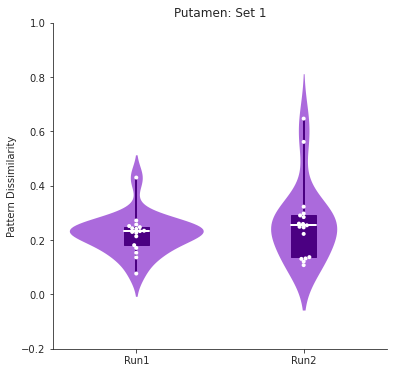

<ipython-input-20-ba6318bba4b5>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(put_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


Set2 Run1 vs. Run2:
t-test (3.992124148292598, 0.0010492570362768245) <---- **
Cohen's d =  1.2876946504629976


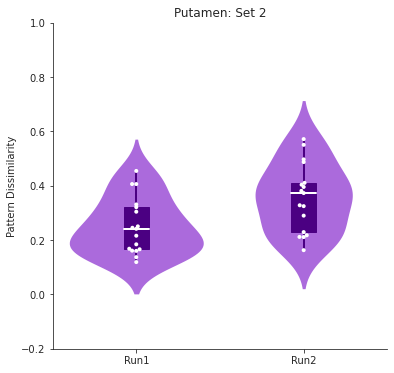

<ipython-input-20-ba6318bba4b5>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(put_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


Set3 Run1 vs. Run2:
t-test (3.976132941140825, 0.0009764242900277065) <---- **
Cohen's d =  1.4426522222362794


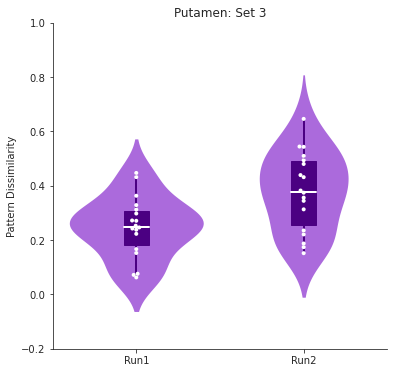

In [20]:
print('Dissimilarity')
for key in ['s1r1', 's1r2','s2r1','s2r2','s3r1','s3r2']:
    print('Mean {0}: '.format(key), np.mean(all_corrs_df['put']['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(all_corrs_df['put']['{0}'.format(key)]))
    print('')
    
for i in range(3):
    N = 2
    conditions = ['Run1','Run2']
    put_allsubjs = [all_corrs_df['put']['s{0}r1'.format(i+1)], all_corrs_df['put']['s{0}r2'.format(i+1)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize=(6,6))
    sns.violinplot(data=put_allsubjs, color='#af52f4', inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(put_allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color='indigo', facecolor='indigo'),
               whiskerprops=dict(color='indigo', linewidth=2, linestyle='-'),
               medianprops=dict(color='w', linewidth=2))
    sns.swarmplot(data=put_allsubjs, size=4, color='white', edgecolor='gray')
    sns.despine(top=True)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel('Pattern Dissimilarity')
    ax.set_title('Putamen: Set {0}'.format(i+1))
    ax.set_ylim(-0.2,1.0)
    print('Set{0} Run1 vs. Run2:'.format(i+1))
    if stats.shapiro(all_corrs_df['put']['s{0}r2'.format(i+1)])[1] < 0.049 or stats.shapiro(all_corrs_df['put']['s{0}r1'.format(i+1)])[1] < 0.049:
        if stats.wilcoxon(all_corrs_df['put']['s{0}r2'.format(i+1)], 
                          all_corrs_df['put']['s{0}r1'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(all_corrs_df['put']['s{0}r2'.format(i+1)], 
                                             all_corrs_df['put']['s{0}r1'.format(i+1)])[:], '<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(all_corrs_df['put']['s{0}r2'.format(i+1)], 
                                             all_corrs_df['put']['s{0}r1'.format(i+1)])[:])
    else:
        if stats.ttest_rel(all_corrs_df['put']['s{0}r2'.format(i+1)], 
                           all_corrs_df['put']['s{0}r1'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
            print('t-test', stats.ttest_rel(all_corrs_df['put']['s{0}r2'.format(i+1)], 
                                            all_corrs_df['put']['s{0}r1'.format(i+1)])[:], '<---- **')
        else:
            print('t-test', stats.ttest_rel(all_corrs_df['put']['s{0}r2'.format(i+1)], 
                                            all_corrs_df['put']['s{0}r1'.format(i+1)])[:])
    cohens_d = ((np.average(all_corrs_df['put']['s{0}r2'.format(i+1)])-np.average(all_corrs_df['put']['s{0}r1'.format(i+1)])) 
                / (sqrt((np.std(all_corrs_df['put']['s{0}r2'.format(i+1)], ddof=1))**2
                        +np.std(all_corrs_df['put']['s{0}r1'.format(i+1)], ddof=1)**2)/2))
    print("Cohen's d = ", cohens_d)
    #plt.savefig("/home/arenf001/figs/RSAw_F_put1_set{0}.png".format(i+1), dpi=1000)
    plt.show() 

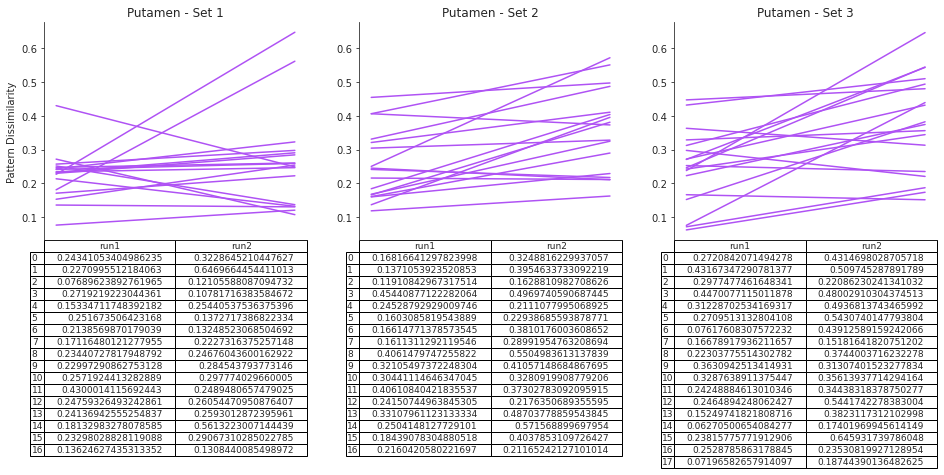

In [21]:
set1 = {}
set2 = {}
set3 = {}
for i in range(3):
    for j in range(2):
        exec('set{0}["run{1}"]=all_corrs_df["put"]["s{0}r{1}"]'.format(i+1,j+1))
for curr_set in ['set1', 'set2', 'set3']:
    exec('{0}=pd.DataFrame({0})'.format(curr_set)) 
set_conditions = ['Run1', 'Run2']
conditions = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6']
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(16,4), sharex=False, sharey=True)
sns.despine(top=True)
df1 = pd.DataFrame(set1.T)
df2 = pd.DataFrame(set2.T)
df3 = pd.DataFrame(set3.T)
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
df1.plot(table=True, ax=ax1, legend=False, color='#af52f4')
df2.plot(table=True, ax=ax2, legend=False, color='#af52f4')
df3.plot(table=True, ax=ax3, legend=False, color='#af52f4')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylabel('Pattern Dissimilarity')
ax1.set_title('Putamen - Set 1')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title('Putamen - Set 2')
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_title('Putamen - Set 3')
plt.show()

<ipython-input-22-2f90c06fb8c6>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2 = fig.add_subplot(grid[0,1], xticklabels=conditions, sharey=ax1)
<ipython-input-22-2f90c06fb8c6>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3 = fig.add_subplot(grid[0,2], xticklabels=conditions, sharey=ax1)
<ipython-input-22-2f90c06fb8c6>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4 = fig.add_subplot(grid[1,:3], xticklabels=conditions)


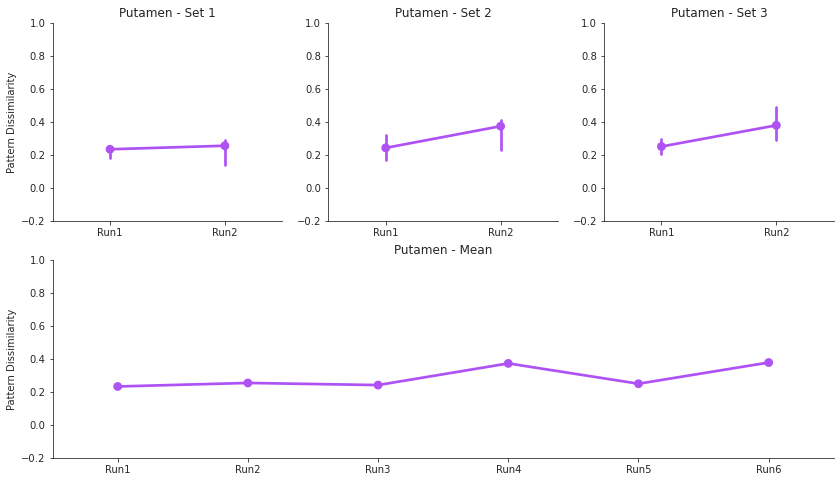

In [22]:
set1 = {}
set2 = {}
set3 = {}
for i in range(3):
    for j in range(2):
        exec('set{0}["run{1}"]=all_corrs_df["put"]["s{0}r{1}"]'.format(i+1,j+1))
for curr_set in ['set1', 'set2', 'set3']:
    exec('{0}=pd.DataFrame({0})'.format(curr_set)) 
set_conditions = ['Run1', 'Run2']
meansubjs = [all_corrs_df['put']['s1r1'], all_corrs_df['put']['s1r2'],
             all_corrs_df['put']['s2r1'], all_corrs_df['put']['s2r2'],
             all_corrs_df['put']['s3r1'], all_corrs_df['put']['s3r2']]
conditions = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6']
ind = np.arange(N)
fig = plt.figure(figsize=(14,8))
grid = plt.GridSpec(2,3)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1], xticklabels=conditions, sharey=ax1)
ax3 = fig.add_subplot(grid[0,2], xticklabels=conditions, sharey=ax1)
ax4 = fig.add_subplot(grid[1,:3], xticklabels=conditions)
sns.despine(top=True)
sns.pointplot(data=set1, color='#af52f4', ax=ax1, estimator=np.median) 
sns.pointplot(data=set2, color='#af52f4', ax=ax2, estimator=np.median)
sns.pointplot(data=set3, color='#af52f4', ax=ax3, estimator=np.median)
sns.pointplot(data=meansubjs, color='#af52f4', ax=ax4, estimator=np.median, ci=False)
ax1.set_xticklabels(set_conditions)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylim(-0.2,1.0)
ax1.set_ylabel('Pattern Dissimilarity')
ax1.set_title('Putamen - Set 1')
ax2.set_xticklabels(set_conditions)
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title('Putamen - Set 2')
ax3.set_xticklabels(set_conditions)
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_title('Putamen - Set 3')
ax4.set_xticklabels(conditions)
ax4.yaxis.set_ticks_position('left')
ax4.xaxis.set_ticks_position('bottom')
ax4.set_ylim(-0.2,1.0)
ax4.set_ylabel('Pattern Dissimilarity')
ax4.set_title('Putamen - Mean')
#plt.savefig("/home/arenf001/figs/RSAw_put4.png".format(i+1), dpi=1000)
plt.show()

SET 1
Early - Run1: (0.3213978522113624, 0.20841993157902944)
Late - Run1: (0.6824881726970055, 0.002538470279299471) <---- **


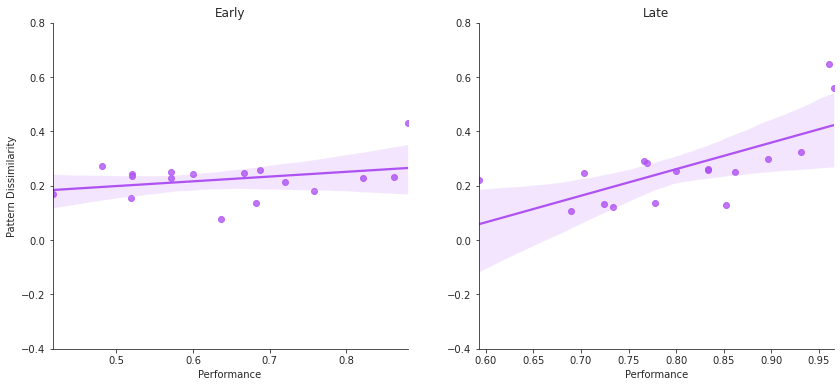

SET 2
Early - Run1: (0.47316355753922396, 0.055071685695554075)
Late - Run1: (0.7555855635170221, 0.0004517374439811247) <---- **


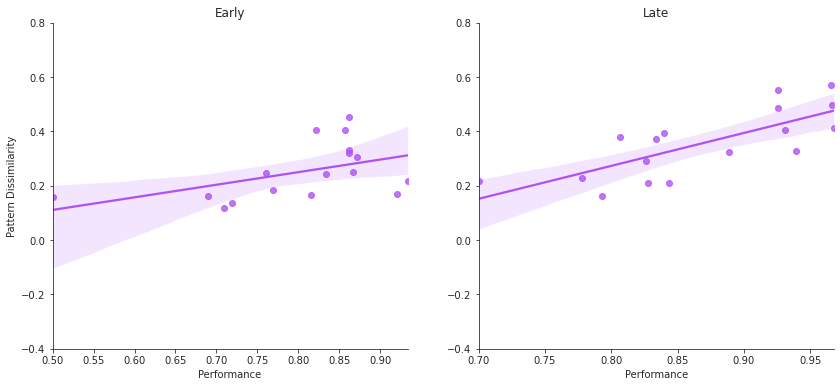

SET 3
Early - Run1: (0.6764074288259659, 0.0020542044329046605) <---- **
Late - Run1: (0.7596791412791665, 0.00025466017895374557) <---- **


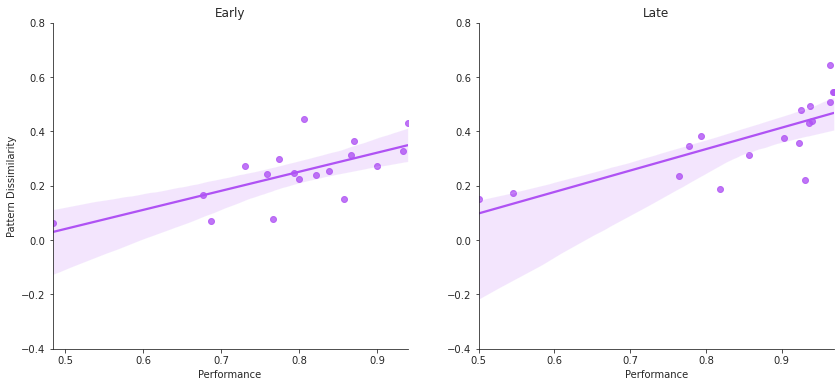

In [23]:
for i in range(3):
    early_plot = {}
    early_plot['brain'] = all_corrs_df['put']['s{0}r1'.format(i+1)]
    early_plot['behavior'] = all_prop_corr['s{0}r1'.format(i+1)]
    early_plot = pd.DataFrame(early_plot)
    late_plot = {}
    late_plot['brain'] = all_corrs_df['put']['s{0}r2'.format(i+1)]
    late_plot['behavior'] = all_prop_corr['s{0}r2'.format(i+1)]
    late_plot = pd.DataFrame(late_plot)
    print('SET {0}'.format(i+1))
    if pearsonr(early_plot['brain'],early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print('Early - Run1:', pearsonr(early_plot['brain'],early_plot['behavior'])[:], '<---- **')
    else:
        print('Early - Run1:', pearsonr(early_plot['brain'],early_plot['behavior'])[:])
    if pearsonr(late_plot['brain'],late_plot['behavior'])[:][-1] < 0.0083:        
        print('Late - Run1:', pearsonr(late_plot['brain'],late_plot['behavior'])[:], '<---- **')
    else:
        print('Late - Run1:', pearsonr(late_plot['brain'],late_plot['behavior'])[:])
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,6), sharex=False, sharey=True)
    sns.despine(top=True)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax1 = sns.regplot(x='behavior', y='brain', data=early_plot, color='#af52f4', ax=ax1)
    ax1.set_ylabel('Pattern Dissimilarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    ax1.set_ylim(-0.4,0.8)
    ax2 = sns.regplot(x='behavior', y='brain', data=late_plot, color='#af52f4', ax=ax2)
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig('/home/arenf001/figs/RSAw_F_put2_run{0}.png'.format(i+1), dpi=1000)
    plt.show()

## Ventral Occipital

Dissimilarity
Mean s1r1:  0.14693590781649302
STD s1r1:  0.06654456598562267

Mean s1r2:  0.1539473161479853
STD s1r2:  0.08595125947248748

Mean s2r1:  0.1569192273403559
STD s2r1:  0.07592586445954884

Mean s2r2:  0.24739387539601995
STD s2r2:  0.13568309974390566

Mean s3r1:  0.19203534847603446
STD s3r1:  0.11695410084250318

Mean s3r2:  0.28390756284835866
STD s3r2:  0.17984312348696999

Set1 Run1 vs. Run2:
Wilcoxon (63.0, 0.54766845703125)
Cohen's d =  0.1251524203278619


<ipython-input-24-ab0f8d38a21b>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


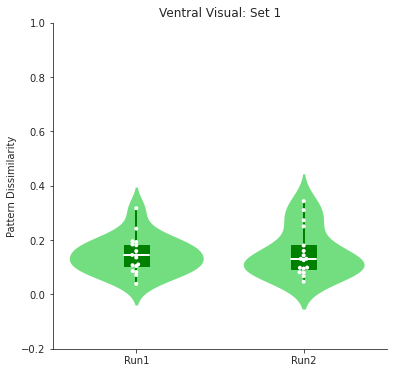

Set2 Run1 vs. Run2:
t-test (2.4339478570414594, 0.02702645886168021)
Cohen's d =  1.129048028974046


<ipython-input-24-ab0f8d38a21b>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


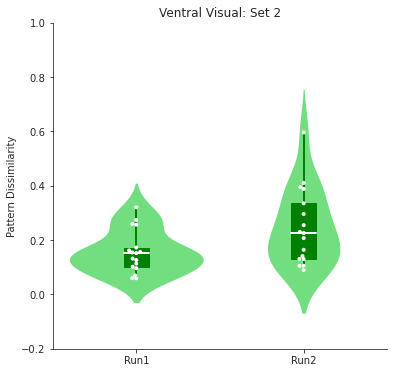

<ipython-input-24-ab0f8d38a21b>:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,


Set3 Run1 vs. Run2:
t-test (2.4726945174579607, 0.024264690954112565)
Cohen's d =  0.8323778919899308


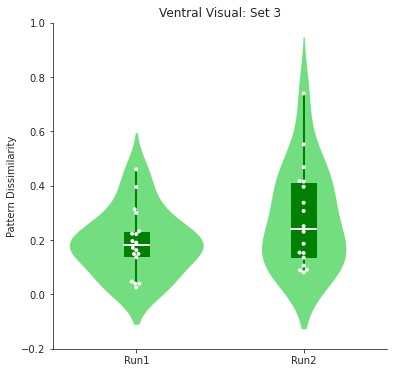

In [24]:
print('Dissimilarity')
for key in ['s1r1', 's1r2','s2r1','s2r2','s3r1','s3r2']:
    print('Mean {0}: '.format(key), np.mean(all_corrs_df['vocc']['{0}'.format(key)]))
    print('STD {0}: '.format(key), np.std(all_corrs_df['vocc']['{0}'.format(key)]))
    print('')
    
for i in range(3):
    N = 2
    conditions = ['Run1','Run2']
    allsubjs = [all_corrs_df['vocc']['s{0}r1'.format(i+1)], all_corrs_df['vocc']['s{0}r2'.format(i+1)]]
    ind = np.arange(N)
    fig, ax = plt.subplots(figsize = (6,6))
    sns.violinplot(data=allsubjs, color='#5bf56f', inner=None, linewidth=0, saturation=0.7)
    ax.boxplot(allsubjs, whis='range', positions=ind, widths=0.15, patch_artist=True,
               showcaps=False, boxprops=dict(color='green', facecolor='green'),
               whiskerprops=dict(color='green', linewidth=2, linestyle = '-'),
               medianprops=dict(color='w', linewidth=2))
    sns.swarmplot(data=allsubjs, size=4, color='white', edgecolor='gray')
    sns.despine(top=True)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(ind)
    ax.set_xticklabels(conditions)
    ax.set_ylabel('Pattern Dissimilarity')
    ax.set_title('Ventral Visual: Set {0}'.format(i+1))
    ax.set_ylim(-0.2,1.0)
    print('Set{0} Run1 vs. Run2:'.format(i+1)) 
    if stats.shapiro(all_corrs_df['vocc']['s{0}r2'.format(i+1)])[1] < 0.049 or stats.shapiro(all_corrs_df['vocc']['s{0}r1'.format(i+1)])[1] < 0.049:
        if stats.wilcoxon(all_corrs_df['vocc']['s{0}r2'.format(i+1)], 
                          all_corrs_df['vocc']['s{0}r1'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
            print('Wilcoxon', stats.wilcoxon(all_corrs_df['vocc']['s{0}r2'.format(i+1)], 
                                             all_corrs_df['vocc']['s{0}r1'.format(i+1)])[:], '<---- **')
        else:
            print('Wilcoxon', stats.wilcoxon(all_corrs_df['vocc']['s{0}r2'.format(i+1)], 
                                             all_corrs_df['vocc']['s{0}r1'.format(i+1)])[:])
    else:
        if stats.ttest_rel(all_corrs_df['vocc']['s{0}r2'.format(i+1)], 
                           all_corrs_df['vocc']['s{0}r1'.format(i+1)])[:][-1] < 0.017: #correction for multi comparisons
            print('t-test', stats.ttest_rel(all_corrs_df['vocc']['s{0}r2'.format(i+1)], 
                                            all_corrs_df['vocc']['s{0}r1'.format(i+1)])[:], '<---- **')
        else:
            print('t-test', stats.ttest_rel(all_corrs_df['vocc']['s{0}r2'.format(i+1)], 
                                            all_corrs_df['vocc']['s{0}r1'.format(i+1)])[:])
    cohens_d = ((np.average(all_corrs_df['vocc']['s{0}r2'.format(i+1)])-np.average(all_corrs_df['vocc']['s{0}r1'.format(i+1)])) 
                /(sqrt((np.std(all_corrs_df['vocc']['s{0}r2'.format(i+1)], ddof=1))**2 
                       +np.std(all_corrs_df['vocc']['s{0}r1'.format(i+1)], ddof=1)**2)/2))
    print("Cohen's d = ", cohens_d) 
    #plt.savefig("/home/arenf001/figs/RSAw_F_vocc1_set{0}.png".format(i+1), dpi=1000)
    plt.show() 

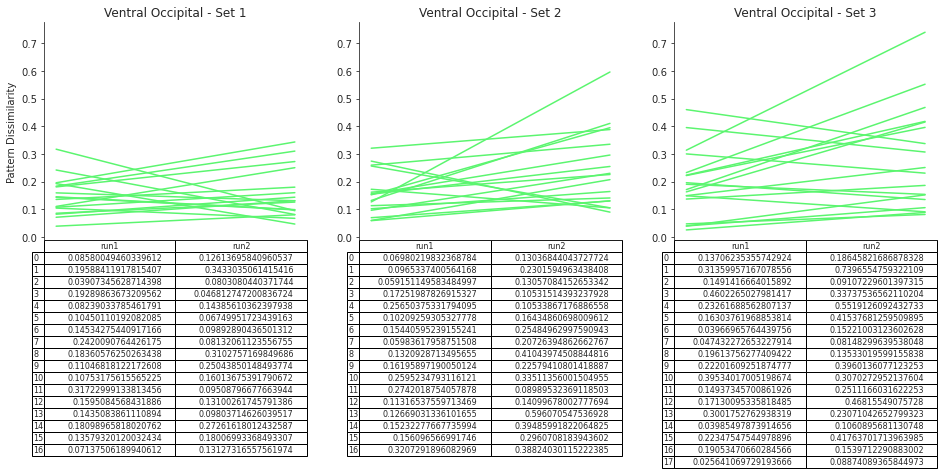

In [25]:
set1 = {}
set2 = {}
set3 = {}
for i in range(3):
    for j in range(2):
        exec('set{0}["run{1}"]=all_corrs_df["vocc"]["s{0}r{1}"]'.format(i+1,j+1))
for curr_set in ['set1', 'set2', 'set3']:
    exec('{0}=pd.DataFrame({0})'.format(curr_set)) 
set_conditions = ['Run1', 'Run2']
conditions = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6']
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(16,4), sharex=False, sharey=True)
sns.despine(top=True)
df1 = pd.DataFrame(set1.T)
df2 = pd.DataFrame(set2.T)
df3 = pd.DataFrame(set3.T)
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
df1.plot(table=True, ax=ax1, legend=False, color='#5bf56f')
df2.plot(table=True, ax=ax2, legend=False, color='#5bf56f')
df3.plot(table=True, ax=ax3, legend=False, color='#5bf56f')
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylabel('Pattern Dissimilarity')
ax1.set_title('Ventral Occipital - Set 1')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title('Ventral Occipital - Set 2')
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_title('Ventral Occipital - Set 3')
plt.show()

<ipython-input-26-f093d775d7e9>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2 = fig.add_subplot(grid[0,1], xticklabels=conditions, sharey=ax1)
<ipython-input-26-f093d775d7e9>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3 = fig.add_subplot(grid[0,2], xticklabels=conditions, sharey=ax1)
<ipython-input-26-f093d775d7e9>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4 = fig.add_subplot(grid[1,:3], xticklabels=conditions)


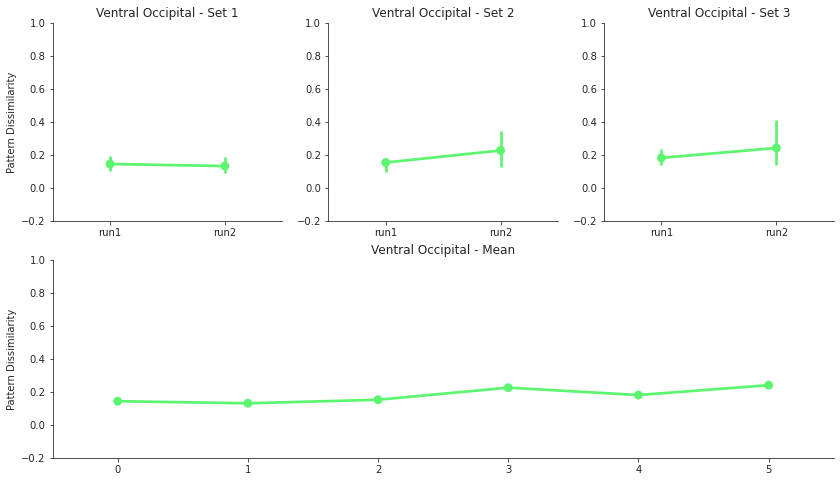

In [26]:
set1 = {}
set2 = {}
set3 = {}
for i in range(3):
    for j in range(2):
        exec('set{0}["run{1}"]=all_corrs_df["vocc"]["s{0}r{1}"]'.format(i+1,j+1))
for curr_set in ['set1', 'set2', 'set3']:
    exec('{0}=pd.DataFrame({0})'.format(curr_set)) 
set_conditions = ['Run1', 'Run2']
vocc_meansubjs = [all_corrs_df['vocc']['s1r1'], all_corrs_df['vocc']['s1r2'],
                  all_corrs_df['vocc']['s2r1'], all_corrs_df['vocc']['s2r2'],
                  all_corrs_df['vocc']['s3r1'], all_corrs_df['vocc']['s3r2']]
conditions = ['Run1', 'Run2', 'Run3', 'Run4', 'Run5', 'Run6']
ind = np.arange(N)
fig = plt.figure(figsize=(14,8))
grid = plt.GridSpec(2,3)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1], xticklabels=conditions, sharey=ax1)
ax3 = fig.add_subplot(grid[0,2], xticklabels=conditions, sharey=ax1)
ax4 = fig.add_subplot(grid[1,:3], xticklabels=conditions)
sns.despine(top=True)
sns.pointplot(data=set1, color='#5bf56f', ax=ax1, estimator=np.median) 
sns.pointplot(data=set2, color='#5bf56f', ax=ax2, estimator=np.median)
sns.pointplot(data=set3, color='#5bf56f', ax=ax3, estimator=np.median)
sns.pointplot(data=vocc_meansubjs, color='#5bf56f', ax=ax4, estimator=np.median, ci=False)
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.set_ylabel('Pattern Dissimilarity')
ax1.set_ylim(-0.2,1.0)
ax1.set_title('Ventral Occipital - Set 1')
ax2.yaxis.set_ticks_position('left')
ax2.xaxis.set_ticks_position('bottom')
ax2.set_title('Ventral Occipital - Set 2')
ax3.yaxis.set_ticks_position('left')
ax3.xaxis.set_ticks_position('bottom')
ax3.set_title('Ventral Occipital - Set 3')
ax4.yaxis.set_ticks_position('left')
ax4.xaxis.set_ticks_position('bottom')
ax4.set_ylim(-0.2,1.0)
ax4.set_ylabel('Pattern Dissimilarity')
ax4.set_title('Ventral Occipital - Mean')
plt.show()

SET 1
Early - Run1: (0.2328300117149638, 0.36848742173284077)
Late - Run1: (0.4059194700638147, 0.10595076574418272)


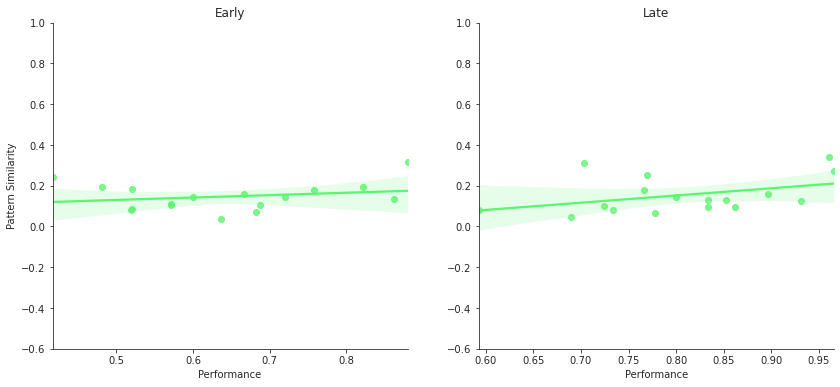

SET 2
Early - Run1: (0.4116328236639113, 0.10066003568419743)
Late - Run1: (0.44933074305139853, 0.070382520153663)


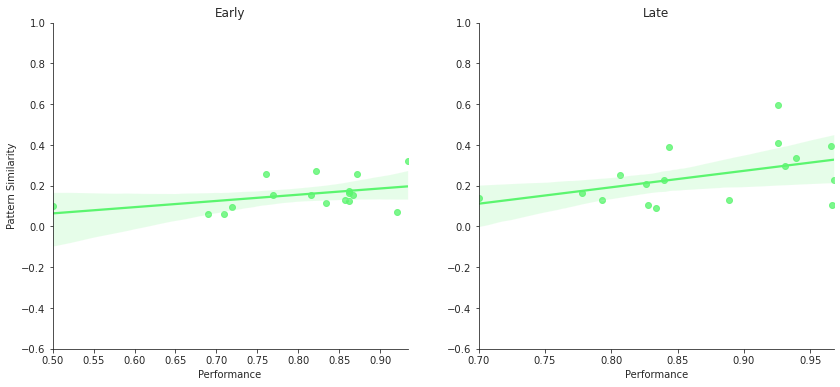

SET 3
Early - Run1: (0.66481375118436, 0.002611490930332335) <---- **
Late - Run1: (0.5457398971851286, 0.01914126556017659)


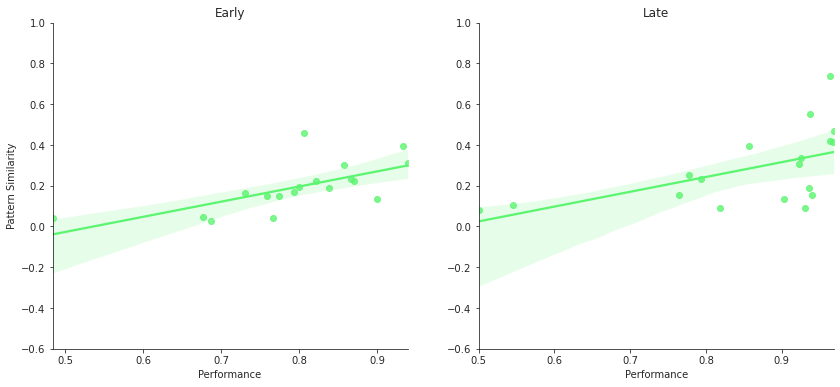

In [27]:
for i in range(3):
    early_plot = {}
    early_plot['brain'] = all_corrs_df['vocc']['s{0}r1'.format(i+1)]
    early_plot['behavior'] = all_prop_corr['s{0}r1'.format(i+1)]
    early_plot = pd.DataFrame(early_plot)
    late_plot = {}
    late_plot['brain'] = all_corrs_df['vocc']['s{0}r2'.format(i+1)]
    late_plot['behavior'] = all_prop_corr['s{0}r2'.format(i+1)]
    late_plot = pd.DataFrame(late_plot)
    print('SET {0}'.format(i+1))
    if pearsonr(early_plot['brain'], early_plot['behavior'])[:][-1] < 0.0083: #correction for multi comparisons       
        print('Early - Run1:', pearsonr(early_plot['brain'], early_plot['behavior'])[:], '<---- **')
    else:
        print('Early - Run1:', pearsonr(early_plot['brain'], early_plot['behavior'])[:])
    if pearsonr(late_plot['brain'], late_plot['behavior'])[:][-1] < 0.0083:        
        print('Late - Run1:', pearsonr(late_plot['brain'], late_plot['behavior'])[:], '<---- **')
    else:
        print('Late - Run1:', pearsonr(late_plot['brain'], late_plot['behavior'])[:])
    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(14,6), sharex=False, sharey=True)
    sns.despine(top=True)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')
    ax1 = sns.regplot(x='behavior', y='brain', data=early_plot, color='#5bf56f', ax=ax1)
    ax1.set_ylabel('Pattern Similarity')
    ax1.set_xlabel('Performance')
    ax1.set_title('Early')
    ax1.set_ylim(-0.6,1.0)
    ax2 = sns.regplot(x='behavior', y='brain', data=late_plot, color='#5bf56f', ax=ax2)
    ax2.yaxis.set_ticks_position('left')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.set_ylabel('')
    ax2.set_xlabel('Performance')
    ax2.set_title('Late')
    #plt.savefig('/home/arenf001/figs/RSAw_F_vocc2_set{0}.png'.format(i+1), dpi=1000)
    plt.show()